Author: Alexis Laignelet

Date: 06/09/19

# Import packages

In [1]:
import numpy as np
import torch
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from scipy.stats import ortho_group

# Generate matrices

In [2]:
# Generate the matrices A and b with a certain zise, and condition number
# The problem to solve is 1/2||AX -b||^2

def generate(m, n, cond):
    
    # For reproductibility purpose
    np.random.seed(0)
    torch.manual_seed(0)
    
    # Generate orthogonal matrices
    U = ortho_group.rvs(dim=m)
    V = ortho_group.rvs(dim=n)
    
    # Build the matrix of singular values
    S = np.diag(np.linspace(1, cond, n))
    S = np.vstack((S, np.zeros((m-n, n))))
    
    # Build A and b
    A = U @ S @ V.T
    b = torch.rand(m).reshape(m,1)
    A = torch.from_numpy(A).float()
    
    return A, b

In [3]:
# Size of matrices and condition number of A

m = 30
n = 20
cond = 1000

A, b = generate(m, n, cond)

# Objective function

In [4]:
# Define the problem to solve

def obj(X):
    return 1/2*torch.norm(torch.mm(A,X) - b, 2)**2


# Explicit scheme

In [5]:
# Define the learning rate and number of iterations

lr = 2 / (1 + cond**2)
nb_iter = 20

In [6]:
# Instanciate X to be optimised

torch.manual_seed(0)
X = torch.rand(n).reshape(n, 1)
X.requires_grad=True

In [7]:
# Empty list to store loss values
train_loss = np.array([])

# Loop through the iterations
for t in range(nb_iter):
    
    # Calculate the loss
    loss = obj(X)
    
    # Store the value
    train_loss = np.append(train_loss, loss.detach().numpy())
    
    # Calculate every gradients
    loss.backward()

    # Exclude the update from the graph
    with torch.no_grad():
        X -= lr * X.grad
        X.grad.zero_()

# Implicit scheme

In [8]:
# Value of tau (learning rate for implicit scheme)

tau = 1

In [9]:
# The implementation in done in Numpy

def obj_np(X):
    return 1/2*np.linalg.norm(A @ X - b, 2)**2

In [10]:
# Instanciate X to be optimised

torch.manual_seed(0)
X = torch.rand(n).reshape(n, 1)
X.requires_grad=True

In [11]:
# Convert into Numpy

X = X.detach().numpy()
A = A.numpy()
b = b.numpy()

In [12]:
# Define empty list to store loss values
train_loss_implicit = np.array([])

# Go through every iterations
for it in range(nb_iter):
                
    # Compute loss
    loss = obj_np(X)
                
    # Store the current value of the loss
    train_loss_implicit = np.append(train_loss_implicit, loss)
    
    # Exact solution of the 
    X = np.linalg.inv(tau * A.T @ A + np.eye(n)) @ (tau * A.T @ b + X)

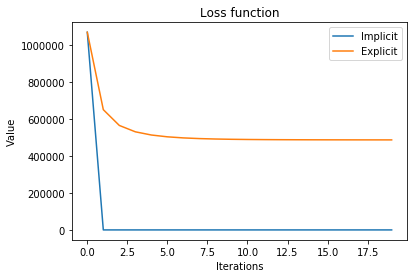

In [13]:
# Plot the results

plt.plot(train_loss_implicit, label='Implicit')
plt.plot(train_loss, label='Explicit')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Loss function')
plt.legend();